In [1]:
import sys
from os.path import abspath, exists
from os import makedirs
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

ROOT_DIR = abspath('../')
sys.path.append(ROOT_DIR)
ROOT_DIR

'/home/mhmunem/finapps/mean-reversion-backtest'

In [2]:
SP500_URL = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
TICKER_FILE_PATH = f"{ROOT_DIR}/data/sp500_tickers.csv"
START_DATE = "2018-01-01"
END_DATE = "2022-12-31"
CSVS_FILE_PATH = f"{ROOT_DIR}/data/sp500/daily/"
PARQUET_FILE_PATH = f"{ROOT_DIR}/data/sp500_stock_data.parquet"

In [3]:
def clean_data(dataframe: pd.DataFrame) -> pd.DataFrame:
    df = dataframe.reset_index()
    # Format the data as per the specified format
    df = df[["Date", "Open", "High", "Low", "Close", "Volume"]]
    df = df.rename(columns={'Date':'timestamp', 'Open':'open', 'High':'high', 
                            'Low':'low','Close':'close', 'Volume':'volume'}) # type: ignore
    
    df["timestamp"] = df["timestamp"].dt.strftime('%Y-%m-%d %H:%M:%S.%f')
    # Round numeric columns to 2 decimal places
    numeric_cols = ["open", "high", "low", "close", "volume"]
    df[numeric_cols] = df[numeric_cols].round(2) 
    df['open'] = df['open'].astype(float)
    df['high'] = df['high'].astype(float)
    df['low'] = df['low'].astype(float)
    df['close'] = df['close'].astype(float)
    df['volume'] = df['volume'].astype(float)
    df = df.dropna()
    df = df.reindex(columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'], index=df.index[::-1])
    df.reset_index(drop=True, inplace=True)
    df.set_index(keys='timestamp', inplace=True)
    return df


def download_tickers():
    data = pd.read_html(SP500_URL)
    sp500_tickers = data[0]['Symbol'].str.replace('.', '-').replace('RVTY (Previously PKI)', 'RVTY').tolist()
    sp500_df = pd.DataFrame(sp500_tickers, columns=['Ticker'])
    print(f"Downloading...")
    # Save to CSV
    sp500_df.to_csv(TICKER_FILE_PATH, index=False)
    print(f"Downloaded")
    

def download_csvs():
    sp500_df = pd.read_csv(TICKER_FILE_PATH)
    sp500_tickers = sp500_df['Ticker'].tolist()
    
    if not exists(CSVS_FILE_PATH):
        makedirs(CSVS_FILE_PATH)

    for ticker in sp500_tickers:
        try:
            data = pdr.get_data_yahoo(ticker, start=START_DATE, end=END_DATE, progress=False)
            data = clean_data(data)
            data.to_csv(f"{CSVS_FILE_PATH}{ticker}.csv")
            print(f"Downloaded data for {ticker}")
        except Exception as e:
            print(f"Error downloading data for {ticker}: {e}")


def download_parquets():
    # Read the CSV file
    sp500_df = pd.read_csv(TICKER_FILE_PATH)
    sp500_tickers = sp500_df['Ticker'].tolist()

    # download dataframe
    sp500_stock_data = pdr.get_data_yahoo(sp500_tickers, start=START_DATE, end=END_DATE)
    sp500_stock_data = sp500_stock_data.rename(columns={'Date':'timestamp', 'Open':'open', 'High':'high', 
                                'Low':'low','Close':'close', 'Volume':'volume'}) # type: ignore
    sp500_stock_data = sp500_stock_data.drop(columns="Adj Close")
    # Swap levels 0 and 1
    sp500_stock_data = sp500_stock_data.swaplevel(0, 1, axis=1)
    #Sort the columns by the levels
    sp500_stock_data = sp500_stock_data.sort_index(axis=1, level=[0, 1])
    #save to parquet file
    sp500_stock_data.to_parquet(PARQUET_FILE_PATH, engine="pyarrow")
    
def download_data(type: str):
    if type == "sp500tickers":
        download_tickers()
    elif type == "sp500csvs":
        download_csvs()
    elif type == "sp500parquet":
        download_parquets()
    

In [39]:
if __name__ == "__main__":
    # download_data("sp500parquet")
    print("running...")

[*********************100%%**********************]  503 of 503 completed


In [4]:
START_DATE = "2018-01-01"
END_DATE = "2022-12-31"
tickers_50 = [ "MMM", "AOS", "BA", "AXON", "CAT", "ABT", "BAX", "BDX", "TECH", "ALGN", "ADBE", "AMD", "AAPL", "CDNS", "NVDA", "AFL", "BAC", "BRK-B", "BX", "COF", "FMC", "IFF", "KLAC", "APD", "CE", "BG", "MO", "CPB", "STZ", "WMT", "TRGP", "VLO", "WMB", "APA", "BKR","DIS", "WBD","GOOGL", "FOX", "EA", "AES", "LNT", "AEP", "AWK", "CEG", "ARE", "BXP", "CPT", "AMT", "CCI" ]
CSVS_FILE_PATH = f"{ROOT_DIR}/data/sp50/daily/"


def clean_data(dataframe: pd.DataFrame) -> pd.DataFrame:
    df = dataframe.reset_index()
    # Format the data as per the specified format
    df = df[["Date", "Open", "High", "Low", "Close", "Volume"]]
    df = df.rename(columns={'Date':'date', 'Open':'open', 'High':'high', 
                            'Low':'low','Close':'close', 'Volume':'volume'}) # type: ignore
    
    df["date"] = df["date"].dt.strftime('%Y-%m-%d %H:%M:%S.%f')
    # Round numeric columns to 2 decimal places
    numeric_cols = ["open", "high", "low", "close", "volume"]
    df[numeric_cols] = df[numeric_cols].round(4) 
    df['open'] = df['open'].astype(float)
    df['high'] = df['high'].astype(float)
    df['low'] = df['low'].astype(float)
    df['close'] = df['close'].astype(float)
    df['volume'] = df['volume'].astype(float)
    df = df.dropna()
    df = df.reindex(columns=['date', 'open', 'high', 'low', 'close', 'volume'], index=df.index[::-1])
    df.reset_index(drop=True, inplace=True)
    df.set_index(keys='date', inplace=True,)
    return df

def download_csvs_sp50():
    sp50_tickers = tickers_50
    
    if not exists(CSVS_FILE_PATH):
        makedirs(CSVS_FILE_PATH)

    for ticker in sp50_tickers:
        try:
            data = pdr.get_data_yahoo(ticker, start=START_DATE, end=END_DATE, progress=False)
            data = clean_data(data)
            data.to_csv(f"{CSVS_FILE_PATH}{ticker}.csv")
            print(f"Downloaded data for {ticker}")
        except Exception as e:
            print(f"Error downloading data for {ticker}: {e}")

            

In [5]:
download_csvs_sp50()

Downloaded data for MMM
Downloaded data for AOS
Downloaded data for BA
Downloaded data for AXON
Downloaded data for CAT
Downloaded data for ABT
Downloaded data for BAX
Downloaded data for BDX
Downloaded data for TECH
Downloaded data for ALGN
Downloaded data for ADBE
Downloaded data for AMD
Downloaded data for AAPL
Downloaded data for CDNS
Downloaded data for NVDA
Downloaded data for AFL
Downloaded data for BAC
Downloaded data for BRK-B
Downloaded data for BX
Downloaded data for COF
Downloaded data for FMC
Downloaded data for IFF
Downloaded data for KLAC
Downloaded data for APD
Downloaded data for CE
Downloaded data for BG
Downloaded data for MO
Downloaded data for CPB
Downloaded data for STZ
Downloaded data for WMT
Downloaded data for TRGP
Downloaded data for VLO
Downloaded data for WMB
Downloaded data for APA
Downloaded data for BKR
Downloaded data for DIS
Downloaded data for WBD
Downloaded data for GOOGL
Downloaded data for FOX
Downloaded data for EA
Downloaded data for AES
Downloade

In [10]:
!zipline ingest -b sp50bundle

[2024-01-30T21:05:33+0600-INFO][zipline.data.bundles.core]
 Ingesting sp50bundle
Loading custom pricing data:   [####################################]  100%
Merging daily equity files:  [####################################]    
[2024-01-30T21:05:34+0600-INFO][root]
 copying /tmp/tmplc9ktcac/sp50bundle/2024-01-30T15;05;32.515192/assets-7.sqlite -> /home/mhmunem/.zipline/data/sp50bundle/2024-01-30T15;05;32.515192
[2024-01-30T21:05:34+0600-INFO][root]
 creating /home/mhmunem/.zipline/data/sp50bundle/2024-01-30T15;05;32.515192/daily_equities.bcolz
[2024-01-30T21:05:34+0600-INFO][root]
 copying /tmp/tmplc9ktcac/sp50bundle/2024-01-30T15;05;32.515192/daily_equities.bcolz/__attrs__ -> /home/mhmunem/.zipline/data/sp50bundle/2024-01-30T15;05;32.515192/daily_equities.bcolz
[2024-01-30T21:05:34+0600-INFO][root]
 creating /home/mhmunem/.zipline/data/sp50bundle/2024-01-30T15;05;32.515192/daily_equities.bcolz/id
[2024-01-30T21:05:34+0600-INFO][root]
 copying /tmp/tmplc9ktcac/sp50bundle/2024-01-30T15

In [19]:
from zipline.api import order_target, record, symbol, order
from zipline import run_algorithm

def initialize(context):
    pass

def handle_data(context, data):
    order(symbol('AAPL'), 10)
    record(AAPL=data.current(symbol('AAPL'), "price"))
           
START_DATE = pd.Timestamp("2018-01-01")
END_DATE = pd.Timestamp("2022-12-31")    
# Run the algorithm
results = run_algorithm(
    start=START_DATE,
    end=END_DATE,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=100_000,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='sp50bundle',
)

/home/mhmunem/.conda/envs/finenv/lib/python3.9/site-packages/zipline/finance/ledger.py:424: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self.daily_returns_series[session_ix] = self.todays_returns


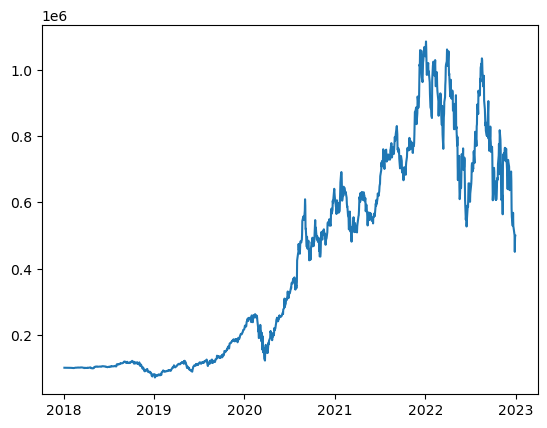

In [20]:
import matplotlib.pyplot as plt

plt.plot(results.portfolio_value)